# Milestone 2: Data collection, preprocessing, exploratory analysis
### On Tonal ambiguity and harmonic structure in Debussy’s piano music
#### By Ludovica Schaerf, Sabrina Laneve , Yuanhui Lin, Raphael Levier.

The notebook is articulated as follows:
1. [Gathering the data](#Gathering-the-data)
2. [Data format](#Data-format)
3. [Exploratory analysis](#Exploratory-analysis)

### Gathering the data

Here you can show that you understand your data and know how to use it. You can be brief in your answers. Section 1 may be supported with informative plots.
-	Describe the dataset you selected and the information represented in it.
-	Based on your research question(s), why did you select this dataset?
-	What aspects of the researched phenomena does the data (not) represent?
-	Where did you get your data from?
-	How did you get it?
-	What is the maximum available amount in theory (in the case of incomplete data acquisition)?
-   If working on partial data, how representative is your sample for the full dataset?


A complete harmonic analysis of Debussy's piano music would theoretically include all Debussy's piano works. However, considering that we want to identify which structures present in the pieces better characterise his style and determine tonal ambiguity, we favor the possibility of an in-depth interpretation of our results based on pivotal pieces.
The main focus of our analysis will be on the piano works which are commonly considered the most representative of Debussy's Impressionistic style: Estampes, Images and Preludes(Webb,Barbara Ellen,"Impressionism in the Piano Music of Claude Debussy" 1962, Masters Theses,4728.https://thekeep.eiu.edu/theses/4728). Secondly, we will look at other works, in particular some earlier ones (Suite Bergamasque, Deux Arabesques) in order to make relevant comparisons. 
We collected the MIDI files of all the pieces of the aforementioned works from [musescore]() and from [this website](). The MIDI scores contain all necessary information to obtain wavescapes. They do not contain harmonic annotations: where appropriate we will manually add harmonic any features that we cannot extract using DFT.

### Data format

This section and the following are the main reason why this milestone is to be delivered in a Jupyter notebook: Give insightful examples for each one of the following questions by loading and transforming data samples.
-	What format(s) does the raw data come in?
-	How is the information that the dataset represents encoded in this format?
-	Load your dataset and show examples of how you access the information that you are interested in.
-	Give an overview of your dataset by plotting some basic statistics of the relevant features and/or metadata.


In [1]:
import music21
import glob
import pandas as pd
import pretty_midi as pm
import tempfile
import IPython.display as ipd

The raw data we work on are all in MIDI format. In the MIDI file, pitches and the corresponding timing information of the score are stored and binary encoded. In order to make the information interpretable for human, a conversion of MIDI file is needed.

Below is an example of the pieces we collected.

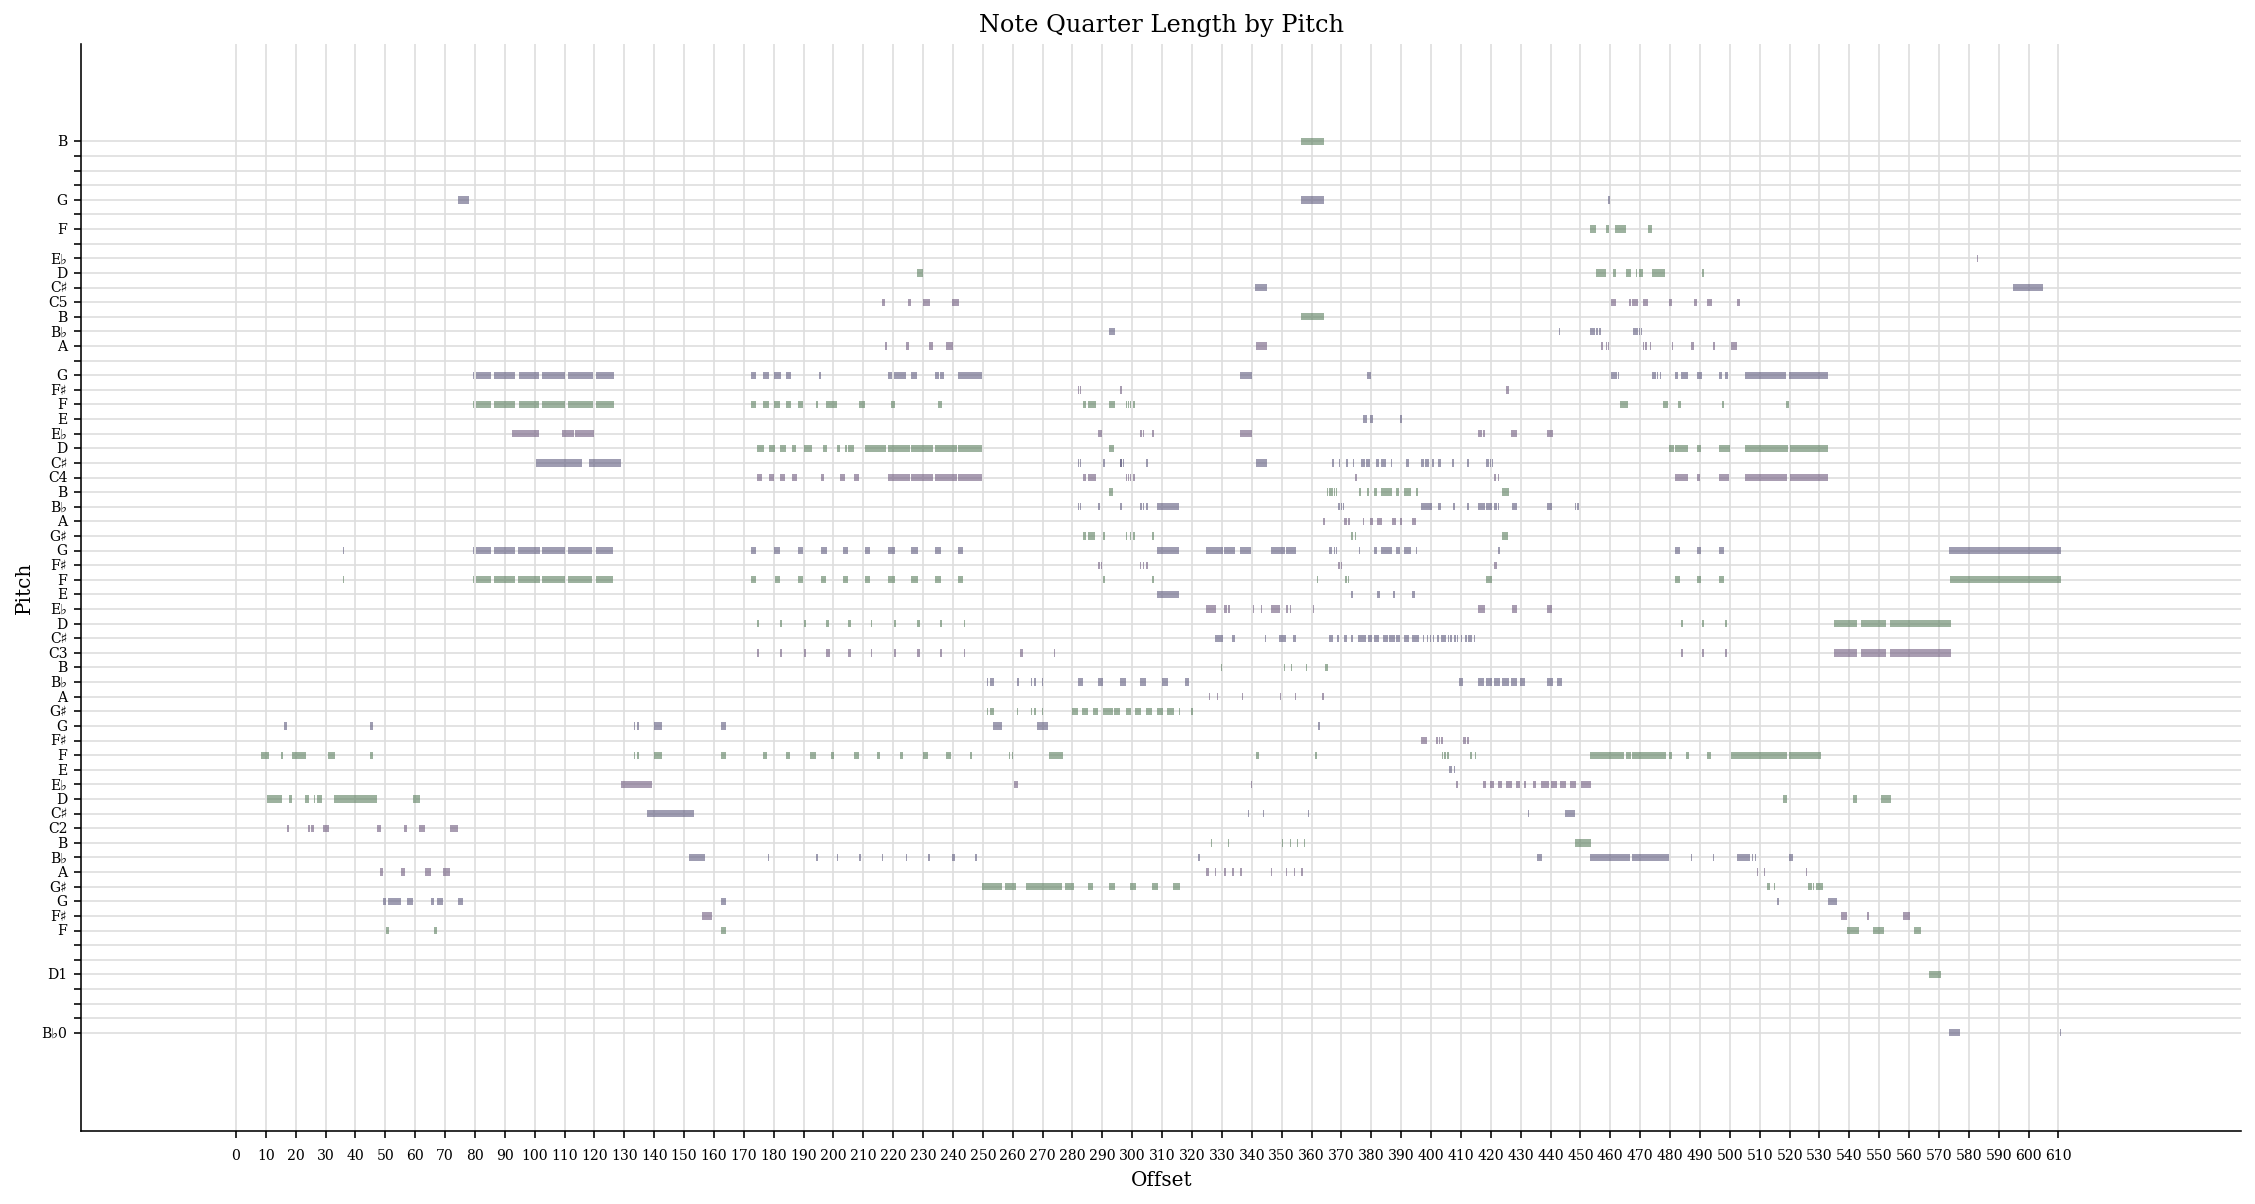

In [2]:
midi_data = music21.converter.parse('./scores/childrens_corner_2_(c)oguri.mid')
midi_data.plot('pianoroll', figureSize=(20, 10))

We use *wavescape* to have a first grasp of the structure of all those pieces. Although *wavescape* library can work on MIDI file directly, it actually utilize the *music21* library to access the pitch information inside the score. To show how this is done, we convert the MIDI files into csv files, where only the score name, pitches name and corresponding onset and offset are stored in a mixed number format.

In [20]:
scores = glob.glob("./scores/*")

score_name_all = []
pitch_name_all = []
pitch_onset_all = []
pitch_offset_all = []

# loop over all scores, save pitch info as csv file
for score in scores: 
    score_name = []
    pitch_name = []
    pitch_onset = []
    pitch_offset = []

    name = score.split('\\')[-1].split('.')[0]
    
    try:
        #
        sound = pm.PrettyMIDI(score)
    
        #getting the track indices of unpitched "percussive" tracks. 
        drum_instruments_index = [idx for idx, instrument in enumerate(sound.instruments) if instrument.is_drum]
        for i in sorted(drum_instruments_index, reverse=True):
            del sound.instruments[i]

        folder = tempfile.TemporaryDirectory()
        temp_midi_filepath = folder.name+'tmp.mid'
        sound.write(temp_midi_filepath)

        ##
        piece = music21.converter.parse(temp_midi_filepath)

        # all note information will be appended together for different tracks
        # for duration, 1.0 is equal to a quarter length
        for elem in piece.recurse():
            if isinstance(elem, music21.note.Note):
                start_offset = elem.getOffsetInHierarchy(piece)
                score_name.append(name)
                pitch_name.append(elem.name)
                pitch_onset.append(music21.common.mixedNumeral(start_offset))
                pitch_offset.append(music21.common.mixedNumeral(start_offset+elem.duration.quarterLength))
                
                score_name_all.append(name)
                pitch_name_all.append(elem.name)
                pitch_onset_all.append(music21.common.mixedNumeral(start_offset))
                pitch_offset_all.append(music21.common.mixedNumeral(start_offset+elem.duration.quarterLength))

            # piteches in chord will be appended seperately
            elif isinstance(elem, music21.chord.Chord):
                start_offset = elem.getOffsetInHierarchy(piece)
                for pit in elem.pitches:
                    score_name.append(name)
                    pitch_name.append(pit.name)
                    pitch_onset.append(music21.common.mixedNumeral(start_offset))
                    pitch_offset.append(music21.common.mixedNumeral(start_offset+elem.duration.quarterLength))
                    
                    score_name_all.append(name)
                    pitch_name_all.append(pit.name)
                    pitch_onset_all.append(music21.common.mixedNumeral(start_offset))
                    pitch_offset_all.append(music21.common.mixedNumeral(start_offset+elem.duration.quarterLength))

        pitch_info = pd.DataFrame(columns = ['score_name', 'pitch_name', 'pitch_onset', 'pitch_offset'])
        pitch_info['score_name'] = score_name
        pitch_info['pitch_name'] = pitch_name
        pitch_info['pitch_onset'] = pitch_onset
        pitch_info['pitch_offset'] = pitch_offset

        pitch_info.to_csv("./csv/"+name+".csv", encoding='utf-8-sig')        
        
    except Exception as e:
        print("Error raised when processing ", name)      

pitch_info_all = pd.DataFrame(columns = ['score_name', 'pitch_name', 'pitch_onset', 'pitch_offset'])
pitch_info_all['score_name'] = score_name_all
pitch_info_all['pitch_name'] = pitch_name_all
pitch_info_all['pitch_onset'] = pitch_onset_all
pitch_info_all['pitch_offset'] = pitch_offset_all
pitch_info_all.to_csv("./csv/all_scores.csv", encoding='utf-8-sig') 

C:\Users\Hazel\Anaconda3\envs\ada\lib\site-packages\pretty_midi\pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


In [3]:
data_example = pd.read_csv("./csv/childrens_corner_2_(c)oguri.csv")
data_example

Unnamed: 0                   score_name pitch_name pitch_onset  \
0             0  childrens_corner_2_(c)oguri          F       8 1/2   
1             1  childrens_corner_2_(c)oguri          F          15   
2             2  childrens_corner_2_(c)oguri          G          16   
3             3  childrens_corner_2_(c)oguri          D      17 3/4   
4             4  childrens_corner_2_(c)oguri          D      23 1/4   
..          ...                          ...        ...         ...   
711         711  childrens_corner_2_(c)oguri          D     235 3/4   
712         712  childrens_corner_2_(c)oguri          F     453 1/3   
713         713  childrens_corner_2_(c)oguri          F     518 3/4   
714         714  childrens_corner_2_(c)oguri          C         182   
715         715  childrens_corner_2_(c)oguri          C         182   

    pitch_offset  
0             11  
1             16  
2         17 1/4  
3         18 3/4  
4        24 7/12  
..           ...  
711      236 1/2  
712      464 2/3  
713      519 3/4  
714      183 3/4  
715      182 3/4  

[716 rows x 5 columns]

For the duration of one pitch, 1 is corresponded to a quarter length. Different tracks will be flattened into one linear presentation of a sequence of pitches, pitches inside one chord will also be sequentialized.

In [5]:
# data overview
all_scores = pd.read_csv("./csv/all_scores.csv")
print(all_scores.shape)

score_names = all_scores['score_name'].unique()
print("In our dataset, there are in total ", len(score_names), " midi files.")

(66742, 5)
In our dataset, there are in total  43  midi files.


In [6]:
norm = lambda df: df.div(df.sum(axis=1), axis=0)

pitch_counts = all_scores.groupby(['score_name','pitch_name']).size().unstack()
pitch_counts = norm(pitch_counts)
pitch_counts

pitch_name                                                 A         B  \
score_name                                                               
Debussy_-_Suite_Bergamasque_-_I                     0.149543  0.039954   
Debussy_-_Suite_Bergamasque_-_II                    0.149440  0.079673   
Debussy_-_Suite_Bergamasque_-_III                   0.026265  0.021781   
Debussy_-_Suite_Bergamasque_-_VI                    0.107044  0.117238   
Debussy_Prelude_Book_2_No_10_Canope                 0.134490  0.028200   
Debussy_Prelude_Book_2_No_11_-_Les_tierces_alte...  0.082474  0.082474   
Debussy_Prelude_Book_2_No_12_Feux_dartifice         0.054826  0.069928   
Debussy_Prelude_Book_2_No_1_Brouillards             0.030025  0.065888   
Debussy_Prelude_Book_2_No_2_Feuilles_mortes         0.105109  0.046715   
Debussy_Prelude_Book_2_No_3_La_puerta_del_vino      0.048117  0.051255   
Debussy_Prelude_Book_2_No_4_Les_fees_sont_dexqu...  0.201531  0.237245   
Debussy_Prelude_Book_2_No_5_Bruyres                 0.025907       NaN   
Debussy_Prelude_Book_2_No_6_General_Lavine_-_ex...  0.072957  0.050584   
Debussy_Prelude_Book_2_No_7_La_terrasse_des_aud...  0.040390  0.114903   
Debussy_Prelude_Book_2_No_8_Ondine                  0.148036  0.073112   
Debussy_Prelude_Book_2_No_9_Hommage_a_S             0.133554  0.028698   
Prélude I - (                                       0.111248  0.037083   
Prélude II - (                                      0.001015  0.001015   
Prélude III - (                                     0.102693  0.242329   
Prélude IV - (                                      0.103147  0.048077   
Prélude IX - (                                      0.050497  0.013007   
Prélude V - (                                       0.018024  0.119950   
Prélude VI - (                                      0.038363  0.071611   
Prélude VIII - (                                         NaN  0.083904   
Prélude X - (                                       0.090106  0.067138   
Prélude XII - (                                     0.091219  0.070759   
childrens_corner_1_(c)oguri                         0.074573  0.066487   
childrens_corner_2_(c)oguri                         0.083799  0.054469   
childrens_corner_3_(c)oguri                         0.033992  0.182609   
childrens_corner_4_(c)oguri                         0.083811  0.025072   
childrens_corner_5_(c)oguri                         0.074405  0.116071   
childrens_corner_6_(c)dery                          0.022087  0.062452   
deuxieme_arabesque                                  0.129353  0.137092   
estamp1_Pagodes                                     0.007465  0.057945   
estamp2_La soirée_dans_Grenade                      0.135537  0.109504   
estamp3_Jardins_sous_la_pluie                       0.078801  0.114017   
images_1_1_(c)oguri                                 0.059343  0.057381   
images_1_2_(c)oguri                                 0.088644  0.118831   
images_1_3_(c)oguri (1)                             0.032749  0.037058   
images_2_1_(c)galimberti                            0.029902  0.117884   
images_2_2_(c)galimberti                            0.093182  0.125000   
images_2_3_(c)galimberti                            0.083847  0.077374   
premiere_arabesque                                  0.124399  0.134708   

pitch_name                                                B-         C  \
score_name                                                               
Debussy_-_Suite_Bergamasque_-_I                     0.097032  0.132991   
Debussy_-_Suite_Bergamasque_-_II                    0.050818  0.103359   
Debussy_-_Suite_Bergamasque_-_III                   0.129404  0.069186   
Debussy_-_Suite_Bergamasque_-_VI                    0.018999  0.025950   
Debussy_Prelude_Book_2_No_10_Canope                 0.065076  0.101952   
Debussy_Prelude_Book_2_No_11_-_Les_tierces_alte...  0.058107  0.135426   
Debussy_Prelude_Book_2_No_12_Feux_dartifice         0.091924  0.117531   
Deb

Text(0, 0.5, "Fraction of piece's note count")

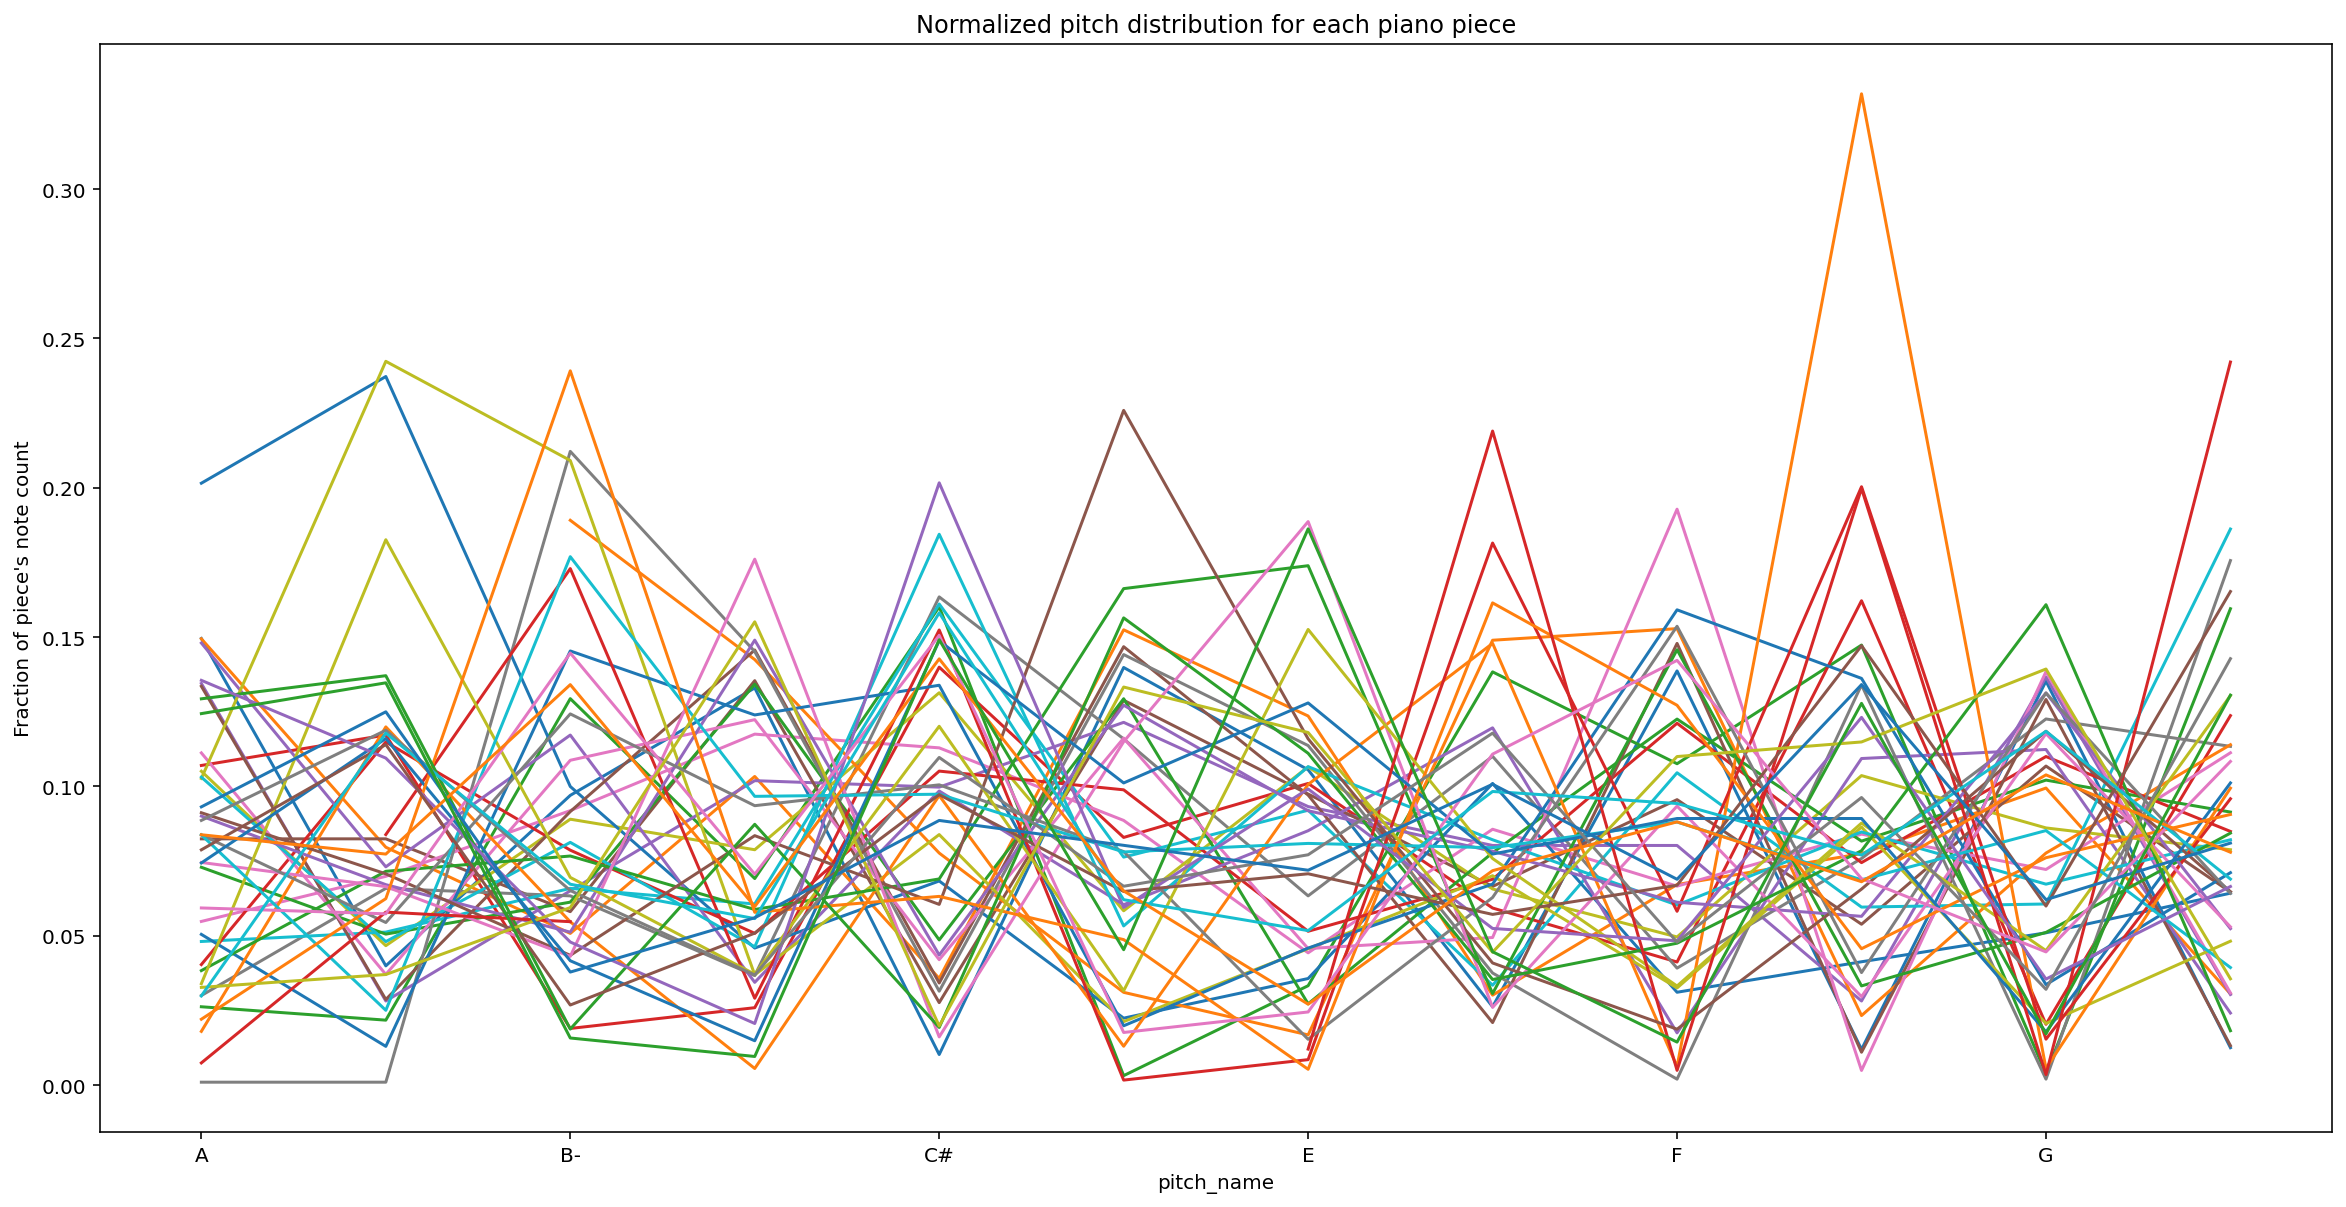

In [14]:
# static plot just in case
import matplotlib.pyplot as plt

ax = pitch_counts.T.plot.line(figsize=(20,10),legend=False, title='Normalized pitch distribution for each piano piece')
ax.set_ylabel("Fraction of piece's note count")
#plt.legend(loc='upper right')

### Exploratory analysis

Perform an exploratory analysis on your data. In this section of your report please address the following points:
-	Which analyses or experiments did you perform as part of your exploratory analysis of the data and what are the results? Choose suitable visualizations to show your results.
-	How do the results relate to your hypotheses?
-	Did you find interesting or unexpected things? How do they influence the development of your project?
-	What are problems that you encountered? How could you plan to deal with them?
-	Discuss how the data enables you to answer your research question(s).
-	Formulate educated guesses on your outcomes based on this data.
-	Reflect on how, at the end of the analysis, you will be able to tell whether these outcomes have manifested or not and how confident you will possibly be about this assessment.



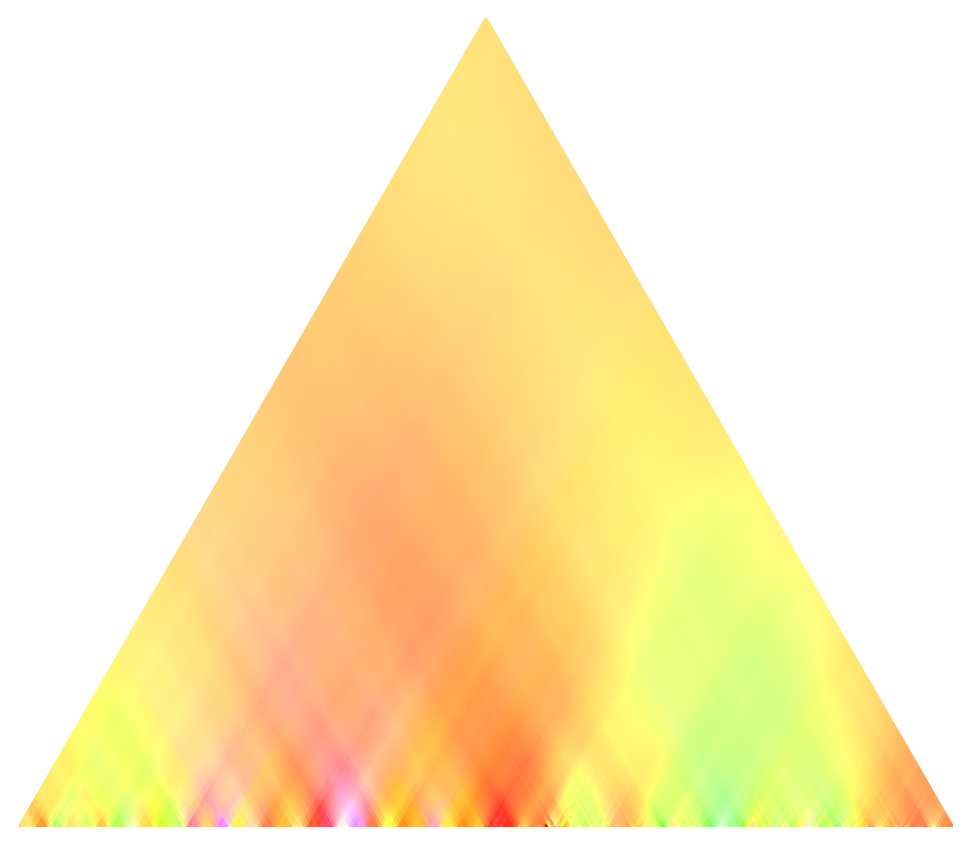

In [7]:
# test
from wavescapes import single_wavescape, all_wavescapes, legend_decomposition
from matplotlib import pyplot as plt

single_wavescape(glob.glob("./*.mid")[0], width=500, coefficient=5, save_label='bache_prelude_5th.png')

In [ ]:
#producing all the plots
import glob
from wavescapes import *
import matplotlib.pyplot as plt

scores = glob.glob("./scores/*.mid")

for score in scores:
    print(str(score.split('\\')[-1].split('.')[0]))
    plt.suptitle(str(score.split('\\')[-1].split('.')[0]) + '\n', fontsize=14)
    if 'images' in score:
        all_wavescapes(score, individual_width=500, aw_size=4, aw_per_tick=4, tick_start=1)
    else:
        all_wavescapes(score, individual_width=500, aw_size=2.5, aw_per_tick=4, tick_start=1)
        
    plt.savefig('./figures/' + str(score.split('\\')[-1].split('.')[0]) + '.png')

childrens_corner_1_(c)oguri


To better interpret the plots:
1. The distribution of magnitudes of the coefficients indicate which scales/chords are detected, as in 
![magnitude_1](figures/magnitude_1.png "Fig.1: Interpreting the magnitude of the coefficients")


2. The color of wavescapes indicates the 'tonic' (or dominant), as in 
![color_1](figures/color_1.png "Fig.2: Interpreting the colors of the plot")


For our preliminary investigation, we used the code by DCMLab on wavescapes which we were given access to on Github. Since we are interested in utilising and, possibly, expanding this method on the specific case of Debussy, we identified as a first step the visualization of all plots using the built-in method and a preliminary interpretation of them. 

An important feature of classical harmony is that tonality can be established only through the "asymmetrical" divisions of the tonal system: because the diatonic, pentatonic, and acoustic scales have a step pattern that does not repeat within the octave, each scale degree is uniquely situated. Conversely, because symmetrical scales have a repeating step pattern, the scale degrees are not unique and there is no way to determine a root. Thus, we could say that tonality goes hand in hand with "asymmetry", while atonality with "symmetry".
In this sense, the magnitude of the 5th coefficient is a strong indicator of the use of symmetrical and more tonal structures in the pieces.

With respect to our hypotheses, we do not see an extremely explicit trend. One first result of our analysis is that in many pieces the 5th coefficients keeps an important role. Even if Debussy is commonly associated with the whole tone scale and he makes large use of it, a strong magnitude of the 6th coefficient does not recur more often than the 5h coefficient. 
In the Suite Bergamasque and in Deux Arabesques, that are some of the earlier pieces, there is a prevalence of asymmetric scales as we would expect. On the other side, even some works which are more associated to the impressionistic style respond almost only to the 5th coefficient. Analyzing the pieces with a strong 5th coefficient, we found a frequent use of the pentatonic scale, sometimes as a constituting element of the whole piece, other times in a smaller section. 
Here it is to be noted that we have no method to distiguish whether the strong presence of the 5th coefficient on a piece indicates the diatonic scales or the pentatonic scale. Currently, we are checking this using manual analyses of the pieces, we will explore better methods to trace this distinction in the future.
Similarly, the 3rd coefficient is associated with many different chords and it is not possible at the moment to find the presence of extended chords. 


Except for the earlier works, no consistent predominance of 1,2 musical structures could be found. Most of the later works appear rather faded on top for all coefficients, some others exhibit very small sections and lots of bright color variations. This, although plausible given the complex structure of the pieces and congruous with our expectations, also complicates our analysis. With respect to the smaller sections, in some cases we found the recurrence of the same small blocks across all coefficients, in other cases instead there is a complementary relashionship between faded and vivid regions of different coefficients. This interplay of different structures (ex. alternance of diatonic and whole tone scale) could be an interesting factor to analyze in order to characterise Debussy's harmonic practice.

Some examples of interpretation of the plots that we found interesting are:

-Debussy, Prelude book 1 No 2 « Voiles » :
For Debussy’s Voiles, the 6th wavescape is the one that stands out : a very opaque red dominates almost all of the plot. In this case, it corresponds to a whole-tone scale, which means that this Prelude almost exclusively consists of one whole-tone scale. Whole-tone scales cause the feeling of tonality to be vague or non existant, which corresponds very well to the feeling that the piece creates. However, a short middle-section of the piece stands out: at two thirds of the piece, wavescape 6 becames suddenly white, while the plot of wavescape 5 moves from white to a strong blue. In this case, it indicates that we transition to a pantatonic scale.

-Debussy, suite Bergamasque III « Clair de Lune »:
Among all the wavescapes generated for Debussy’s Prelude, the 5th stands out the most in terms of resonance with its Fourier coefficient. This wavescape displays the least amount of faded and white colors implying strong magnitude with either diatonic/pentatonic scales. The plot’s strong opacity indicates high values of magnitude at all the different hierarchical levels. It presents one strong dominant color, which indicates the consistent use of one prevalent music structure. This is unlike the other plots where the energy tends to dissipate toward the top of the pyramid. 
These observations tend to confirm the fact that Clair de Lune is not among the most « ambiguous » pieces of Debussy. It maintains a strong feeling of tonality, while using frequently pentatonic scales.

Other examples observations which respond to our hypotheses are:

-Debussy, Prelude book 1 No 8 and 5, Pagodes:
For all these pieces we can associate the 5th coefficient to the presence of pentatonic musical motivs that are developed troughout all the pieces and give them an overall coherence.

-In Reflets dans l'eau we found an alternance of pentatonic/diatonic and whole tone scales, with the 5th coefficient highlighting an overall tonal context

Some cases of interest, instead, are: 
- Debussy_Prelude_Book_2_No_10_Canope: in which the same small block structure is visible for all coefficients
- Debussy_Prelude_Book_2_No_12_Feux_dartifice.png: where the beginning is especially responsive to the first coefficient
- Debussy_Prelude_Book_2_No_1_Brouillards.png: which is particularly responsive to the second coefficient
- Prélude VIII - (.png: which does not respond at all to coefficient 1 and 6.

We are on the process of analyzing possible explanations for these cases. At first sight, the found patterns do not correspond to any previously analyzed characteristic of the piece, we might decide to focus more attention towards these cases to see whether they can tell us more about Debussy's specific style.

In terms of problematics, while analyzing the resulting images, we observed that the 'tonic' extracted by the methods (for example on the 5th coefficient) never matches our expectation based on previous knowledge. In this sense, we wondered whether this could be an issue with the color mapping. We checked Bach's prelude in C major that exhibited these colors in the case study in the paper:

![bach](figures/bach.png "Fig.3: Bach")

bach_846


<Figure size 432x288 with 0 Axes>

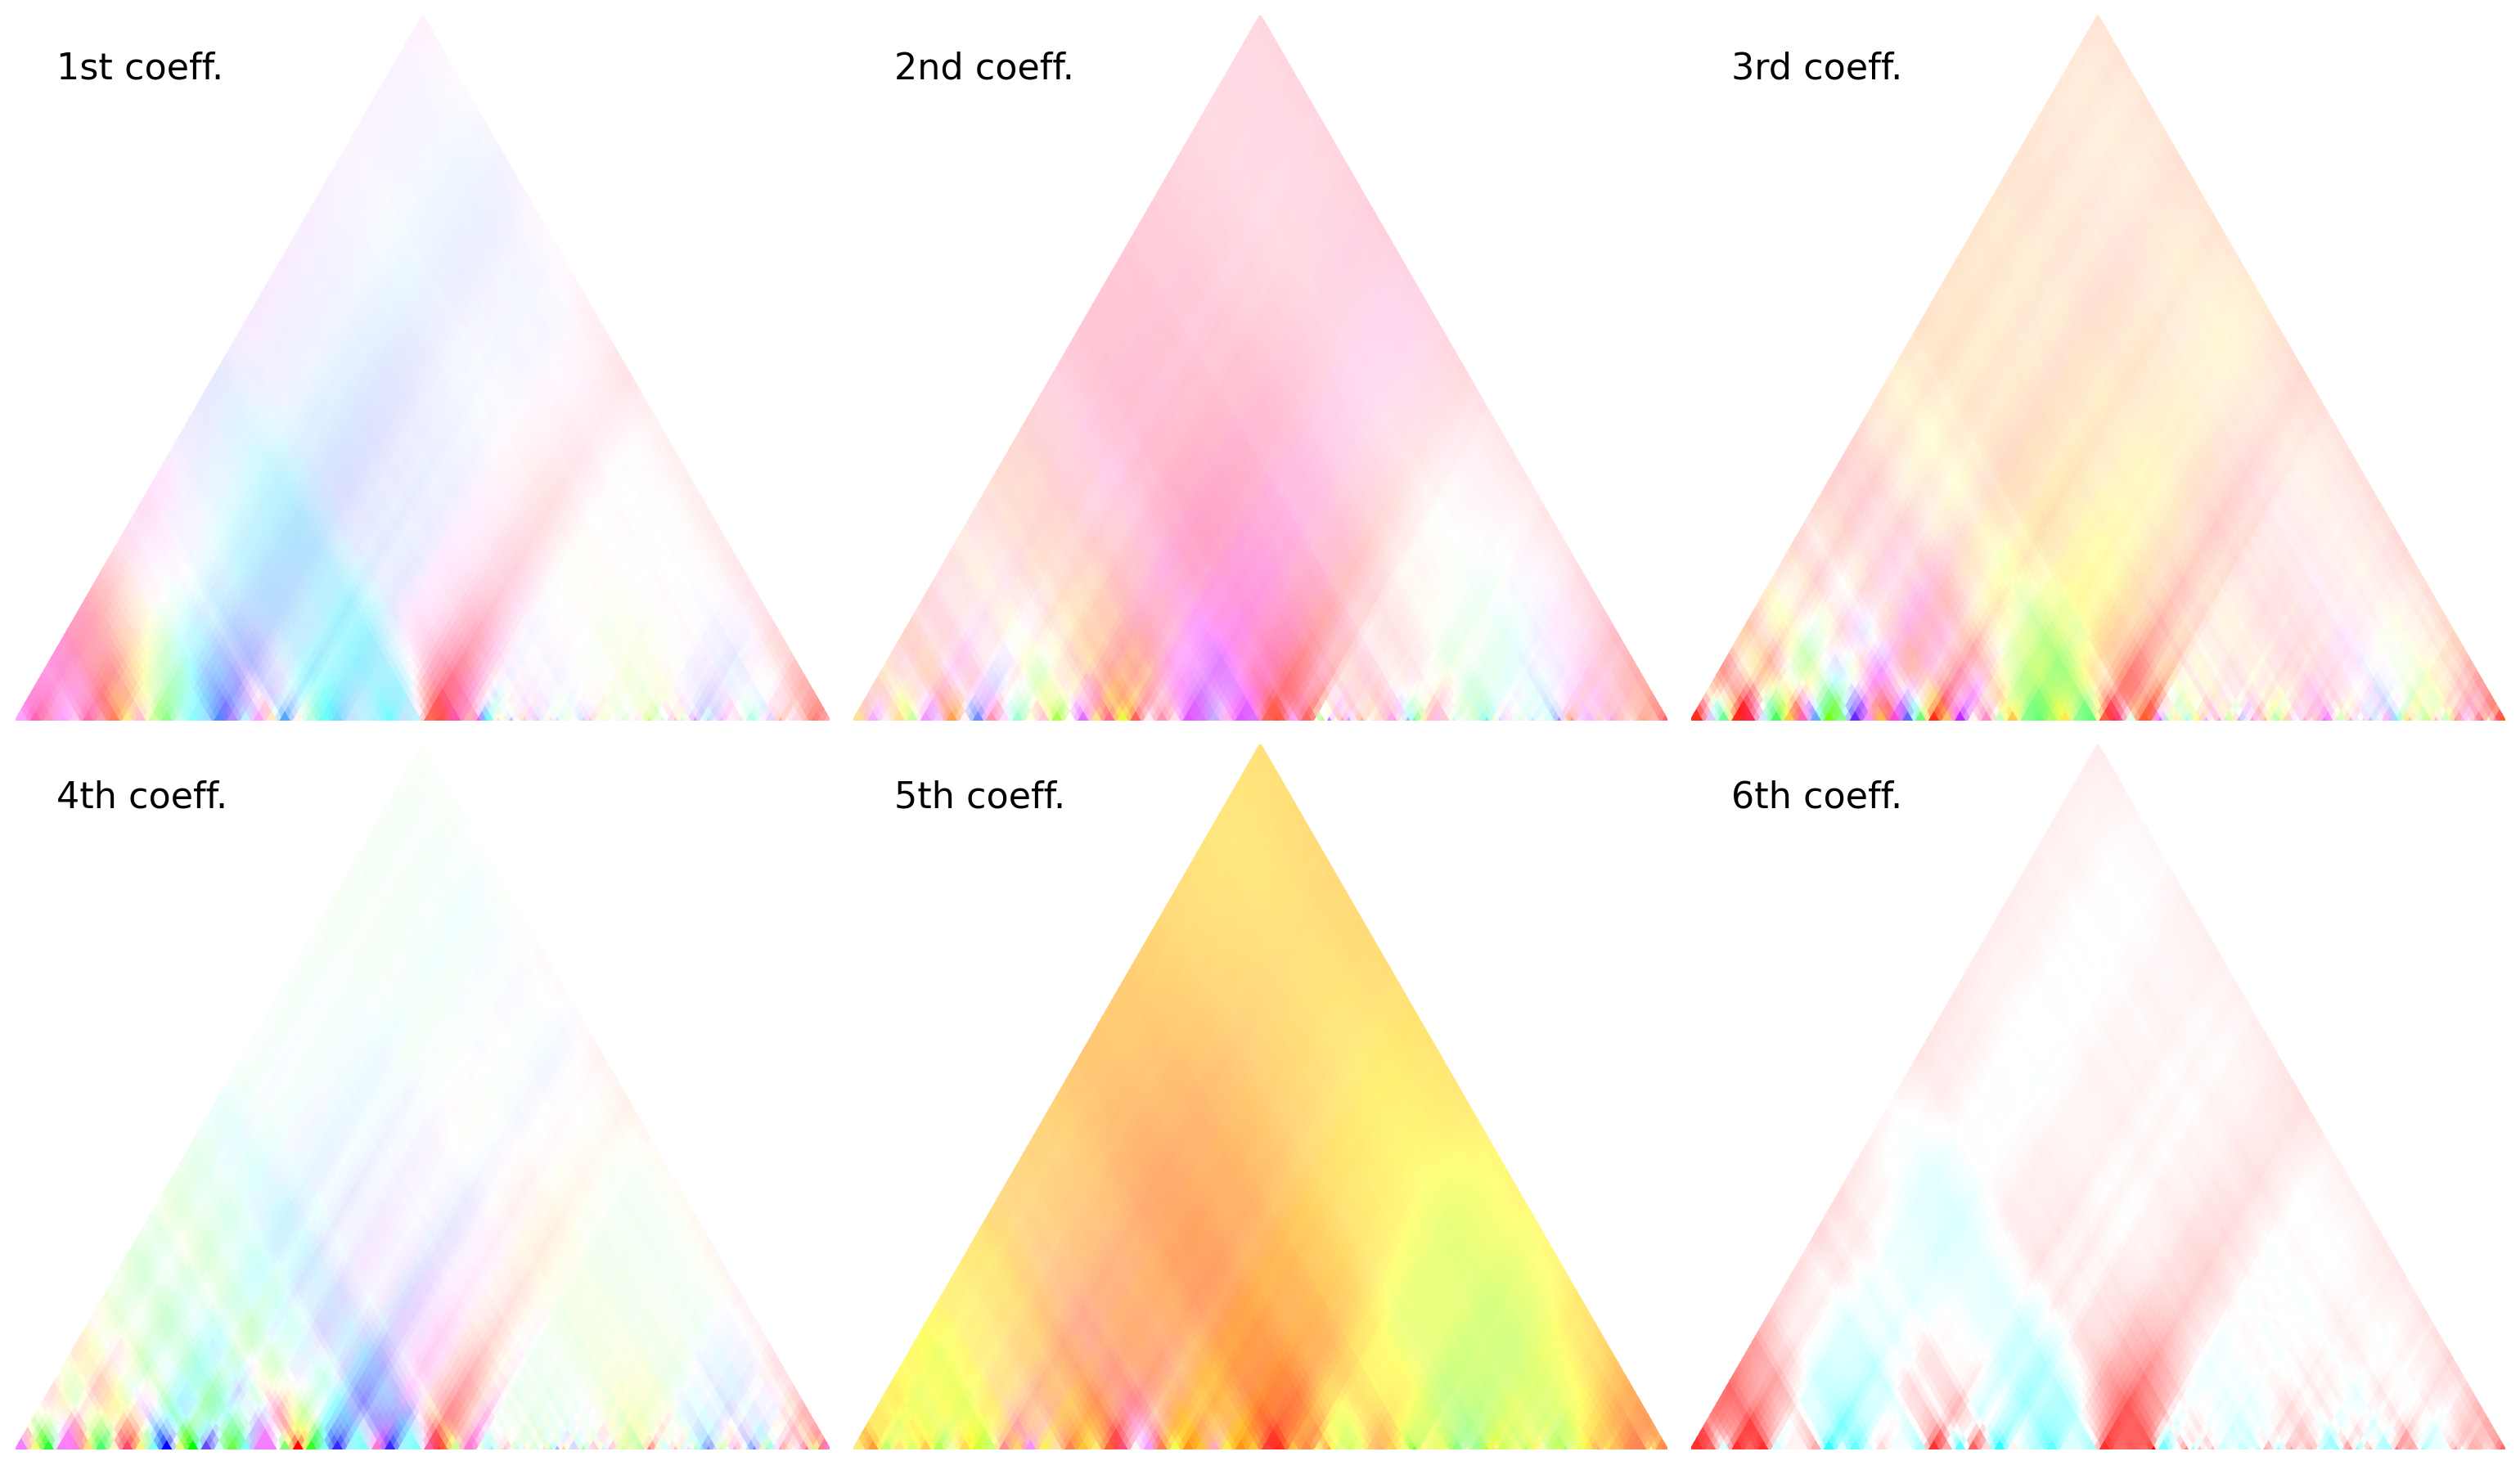

In [8]:
# Bach's prelude in C major
scores = glob.glob("./*.mid")

for score in scores:
    print(str(score.split('\\')[-1].split('.')[0]))
    plt.suptitle(str(score.split('\\')[-1].split('.')[0]) + '\n', fontsize=14)
    all_wavescapes(score, individual_width=500, aw_size=2)
    plt.savefig('./figures/' + str(score.split('\\')[-1].split('.')[0]) + '_1.png')

and, as one can see, the color is indeed different. We looked at the code to check whether we were using a wrong default value but the issue does not seem to be this superficial. We plan to further check the code to see if the mapping or the DFT computation itself are wrong, else we might contact Cedric Viaccoz (or anyone with experience using this code). 

Given these observations, we believe that, in order to answer our research question and determine whether we can observe tonal ambiguity from these plots, we will try to determine in how many cases the plot shows the prevalence a certain structure(ex. asymmetrical structures) in piece. We will also analyse some specific cases as we have done for some of the plots to determine whether other patterns (that are not covered in Figure 1) can indicate tonal ambiguity. We also plan to extend the list of possible distributions of coefficients which we believe indicate tonal ambiguity (i.e. can we consider the response to only the first coefficient an indication of tonal ambiguity?).

Based on these data, we expect to find a strong prevalence of whole-tone scales and pentatonic scales, with extended use of major/minor triads. The relashionship between symmetrical and asymmetrical structure seems to be a relevant factor with respect to our research question. As structures based on chromaticism appear mostly on the lower level, we plan to investigate more on this aspect when performing a more in depth analysis of the pieces.
We have no expectation on the use of keys or progressions as the color was considered unreliable during this first analysis. One idea of exploiting colors can be to observe pattern of harmonic sequences on the lower levels.

Since currently we are interpreting the plots mainly visually, we plan to also automatize the process of detecting the scale/chord presence from Figure 1 numerically. The idea is to use a linear combination of the magnitude of each coefficient at each point and the expected magnitude in the Figure 1. We would then consider the highest value of the linear combination to be the scale/chord present at that point and compute this for every point. For instance, augmented triad will have the following coefficients based on Figure 1: [0,0,1,0,0,1]. When the visual expectation and the algorithmic approach will yield the same result we will consider ourselves confident with the result.



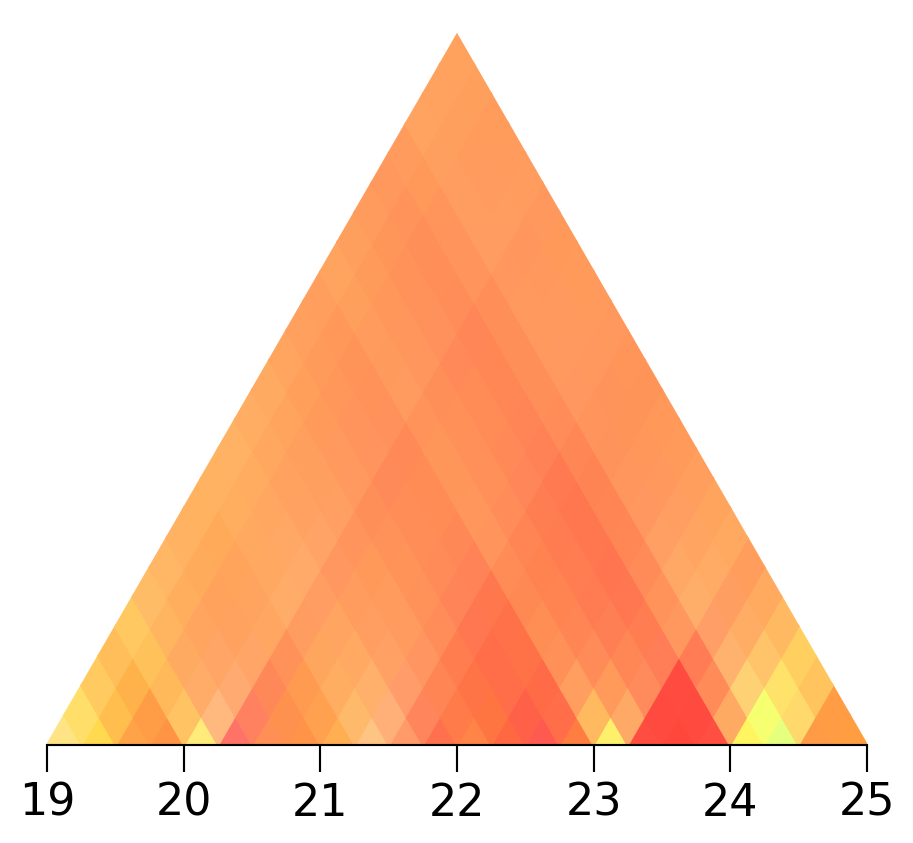

In [12]:
# bar number - 1 * 4
single_wavescape(score, width=500, coefficient=5, aw_size=2.5,
                 aw_per_tick=4, tick_start=1, subparts_highlighted=[72,96])

C:\Users\ludov\anaconda3\envs\ada\lib\site-packages\wavescapes\general.py:342: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['$0$', '', '$\pi/2$', '', '$\pi$', '', '$3\pi/2$', ''])


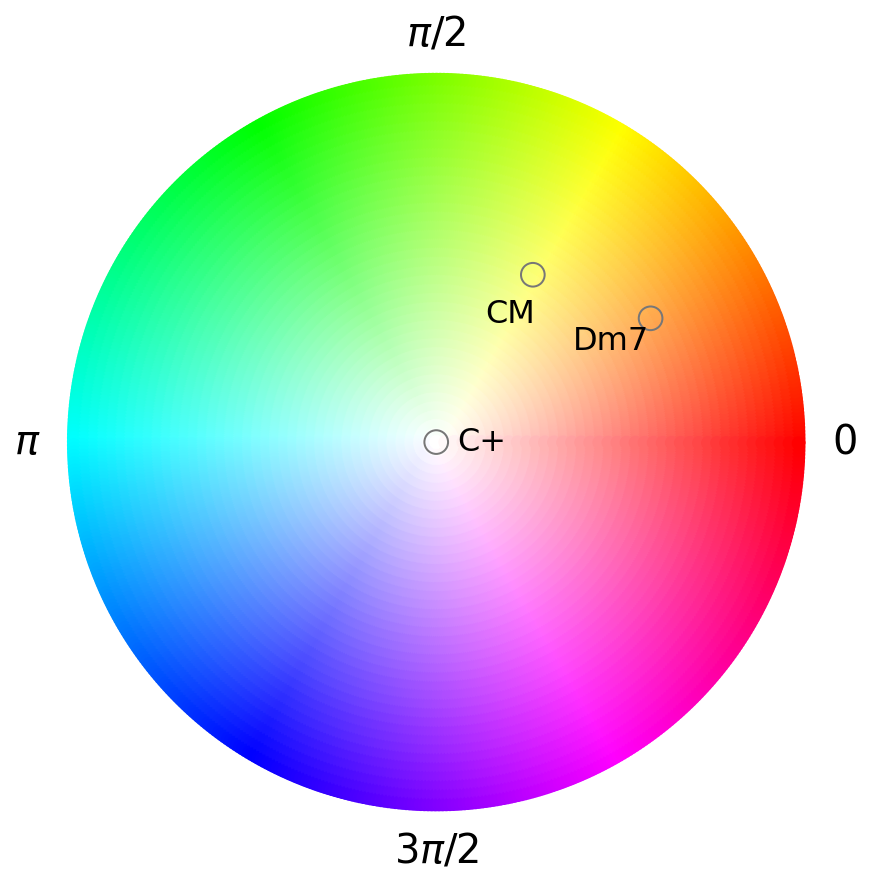

In [15]:
d = {'C+': ([1,0,0,0,1,0,0,0,1,0,0,0], [0]),
     'Dm7': ([1,0,1,0,0,1,0,0,0,1,0,0], [0]),
     'CM': ([1,0,1,0,1,1,0,1,0,1,0,1], [5])}
legend_decomposition(d, single_img_coeff=5, width=7)